In [1]:
import cv2
import os

imagesPath = "/content/drive/MyDrive/Rostrosdesconocidos" 
imagesPathList = os.listdir(imagesPath)

if not os.path.exists('/content/drive/MyDrive/ImagenesGeneradas'):
    print('Carpeta creada: Imagenes Generadas')
    os.makedirs('/content/drive/MyDrive/ImagenesGeneradas')

faceClassif = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')

count = 0
for imageName in imagesPathList:
    image = cv2.imread(imagesPath+'/'+imageName)
    imageAux = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    faces = faceClassif.detectMultiScale(gray, 2.1, 1)

    for (x,y,w,h) in faces:
        cv2.rectangle(image, (x,y),(x+w,y+h),(128,0,255),2)
    cv2.rectangle(image,(10,5),(450,25),(255,255,255),-1)

    for (x,y,w,h) in faces:
            rostro = imageAux[y:y+h,x:x+w]
            rostro = cv2.resize(rostro,(150,150), interpolation=cv2.INTER_CUBIC)
            cv2.waitKey(0)
            cv2.imwrite('/content/drive/MyDrive/ImagenesGeneradas/rostro_{}.jpg'.format(count),rostro)
            count = count +1

cv2.destroyAllWindows()

### Capturando Rostros detectados de un video

In [4]:
import cv2
import os
import imutils

personName = 'Gilberto'
dataPath = '/content/drive/MyDrive/RecolectordeDatos/'
personPath = dataPath + '/' + personName

if not os.path.exists(personPath):
    print('Carpeta creada: ',personPath)
    os.makedirs(personPath)
    
cap = cv2.VideoCapture('/content/drive/MyDrive/Video/bidio.mp4')
print('detectando')


faceClassif = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')

print('YA detectando')
count = 0

while True:

    ret, frame = cap.read()
    if ret == False: break
    frame =  imutils.resize(frame, width=640)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    auxFrame = frame.copy()
                                      
    faces = faceClassif.detectMultiScale(gray,1.2,5)   #(image, scaleFactor, minNeighbors)

    for (x,y,w,h) in faces:
        cv2.rectangle(frame, (x,y),(x+w,y+h),(0,255,0),2)
        rostro = auxFrame[y:y+h,x:x+w]
        rostro = cv2.resize(rostro,(150,150),interpolation=cv2.INTER_CUBIC)
        cv2.imwrite(personPath + '/rotro_{}.jpg'.format(count),rostro)
        count = count + 1
    #cv2.imshow('frame',frame)

    k =  cv2.waitKey(1)
    if k == 27 or count >= 350:
        break
print('FIN')

cap.release()
cv2.destroyAllWindows()

detectando
YA detectando
FIN


### Entrenamiento para reconocimiento de Rostro con CNN

In [5]:
from skimage.io import imread_collection , concatenate_images
import numpy as np
import matplotlib.pyplot as plt
import copy  as cp
import copy

# path 
folderGretel = '/content/drive/MyDrive/RecolectordeDatos/Gilberto/*.jpg'
folderOthers = '/content/drive/MyDrive/ImagenesGeneradas/*.jpg'

# load data 
imagesGretel = imread_collection(folderGretel)
imagesOthers = imread_collection(folderOthers) 

# len
nGretel  = len(imagesGretel)
nOthers = len(imagesOthers)

#HACER RANDOM Y PARA NO SESGASR EL MODELO 
#AUMENTAR DATOS A LA CLASE QUE FALTE PARA TENER IGUAL CANTIDAD Y NO DESBALANCEAR EL MODELO 

# union data
images = np.append(imagesGretel, imagesOthers, axis=0)

print("Total de imagenes: ",len(images))

Total de imagenes:  434


(150, 150, 3)


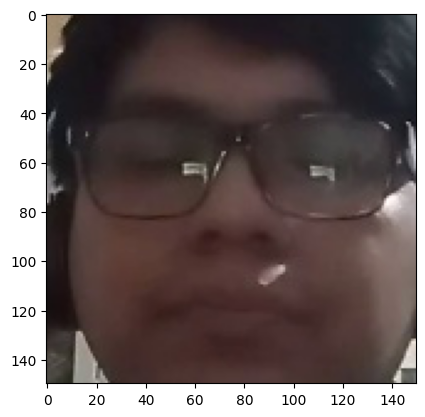

In [6]:
#plot the first image in the dataset
plt.imshow(images[0])
print(images[0].shape)

In [7]:
def Create_Y():
     return [0]*nGretel + [1]*nOthers
Y = Create_Y()

Y = np.array(Y)
X = np.array(images)

(64, 64, 3)


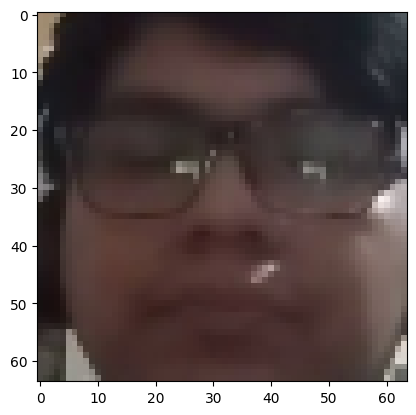

In [8]:
from skimage.transform import resize
X=resize(X,(len(images),64,64,3))

#plot the first image in the dataset
plt.imshow(X[0])
print(X[0].shape)

### Creando la Red Neuronal Convolucional

In [9]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

modelo=Sequential() #Varias capas apiladas entre ellas

modelo.add(Conv2D(200,(3,3),input_shape=X.shape[1:]))
modelo.add(Activation('relu'))
modelo.add(MaxPooling2D(pool_size=(2,2)))
#La primera capa de CNN seguida por las capas de Relu y MaxPooling

modelo.add(Conv2D(100,(3,3)))
modelo.add(Activation('relu'))
modelo.add(MaxPooling2D(pool_size=(2,2)))
#La segunda capa de convolución seguida por las capas de Relu y MaxPooling

modelo.add(Conv2D(50,(3,3)))
modelo.add(Activation('relu'))
modelo.add(MaxPooling2D(pool_size=(2,2)))
#La tercera capa de convolución seguida por las capas de Relu y MaxPooling

modelo.add(Flatten()) #Imagen profunda la vamos a hacer plana, es decir solo una dimension,
#va tener toda nuestra informacion de la cnn

modelo.add(Dropout(0.5)) # Apagamos 50% de las neuronas cada paso, asi evitamos sobreajustar
#(evitar un solo camino de entrenamiento)

modelo.add(Dense(50,activation='relu'))
#Capa Densa de 50 neuronas

modelo.add(Dense(2,activation='softmax')) #La capa final softmax con dos salidas para dos categorías
#Softmax nos indica que tanta probabilidad tiene cada clase, y por ende saber cual tiene la maxima probabilidad

modelo.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [10]:
#Onehot Encoding the labels.
from sklearn.utils.multiclass import unique_labels
from keras.utils import to_categorical

#Ya que tenemos 2 clases debemos esperar que shape[1] de y_train,y_val y y_test cambie de 0 a 1
Y=to_categorical(Y)

Y[0]

array([1., 0.], dtype=float32)

In [11]:
Y[len(Y)-1]

array([0., 1.], dtype=float32)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.30, random_state = 0)

In [13]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/CNN/model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

In [14]:
history=modelo.fit(X_train,Y_train,epochs=20,callbacks=[checkpoint],validation_split=0.2) 

Epoch 1/20
8/8 [==============================] - ETA: 0s - loss: 0.6415 - accuracy: 0.4835

8/8 [==============================] - 23s 2s/step - loss: 0.6415 - accuracy: 0.4835 - val_loss: 0.5489 - val_accuracy: 0.4754
Epoch 2/20
8/8 [==============================] - ETA: 0s - loss: 0.4971 - accuracy: 0.7190

8/8 [==============================] - 13s 2s/step - loss: 0.4971 - accuracy: 0.7190 - val_loss: 0.3490 - val_accuracy: 0.9508
Epoch 3/20
8/8 [==============================] - ETA: 0s - loss: 0.2654 - accuracy: 0.9463

8/8 [==============================] - 13s 2s/step - loss: 0.2654 - accuracy: 0.9463 - val_loss: 0.0784 - val_accuracy: 1.0000
Epoch 4/20
8/8 [==============================] - ETA: 0s - loss: 0.0527 - accuracy: 0.9959

8/8 [==============================] - 13s 2s/step - loss: 0.0527 - accuracy: 0.9959 - val_loss: 0.0075 - val_accuracy: 1.0000
Epoch 5/20
8/8 [==============================] - ETA: 0s - loss: 0.0256 - accuracy: 0.9959

8/8 [==============================] - 13s 2s/step - loss: 0.0256 - accuracy: 0.9959 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 6/20
8/8 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.9959

8/8 [==============================] - 14s 2s/step - loss: 0.0104 - accuracy: 0.9959 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 7/20
8/8 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

8/8 [==============================] - 13s 2s/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 3.6385e-04 - val_accuracy: 1.0000
Epoch 8/20
8/8 [==============================] - ETA: 0s - loss: 0.0392 - accuracy: 0.9876

8/8 [==============================] - 13s 2s/step - loss: 0.0392 - accuracy: 0.9876 - val_loss: 1.6397e-04 - val_accuracy: 1.0000
Epoch 9/20
8/8 [==============================] - 9s 1s/step - loss: 0.1533 - accuracy: 0.9421 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 10/20
8/8 [==============================] - 11s 1s/step - loss: 0.0369 - accuracy: 0.9917 - val_loss: 0.0663 - val_accuracy: 0.9836
Epoch 11/20
8/8 [==============================] - 11s 1s/step - loss: 0.0551 - accuracy: 0.9876 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 12/20
8/8 [==============================] - 8s 1s/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 5.1151e-04 - val_accuracy: 1.0000
Epoch 13/20
8/8 [==============================] - 11s 1s/step - loss: 0.0105 - accuracy: 0.9959 - val_loss: 2.0266e-04 - val_accuracy: 1.0000
Epoch 14/20
8/8 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000

8/8 [==============================] - 12s 2s/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 1.0838e-04 - val_accuracy: 1.0000
Epoch 15/20
8/8 [==============================] - ETA: 0s - loss: 2.0758e-04 - accuracy: 1.0000

8/8 [==============================] - 12s 2s/step - loss: 2.0758e-04 - accuracy: 1.0000 - val_loss: 8.5153e-05 - val_accuracy: 1.0000
Epoch 16/20
8/8 [==============================] - ETA: 0s - loss: 1.8761e-04 - accuracy: 1.0000

8/8 [==============================] - 11s 1s/step - loss: 1.8761e-04 - accuracy: 1.0000 - val_loss: 7.7658e-05 - val_accuracy: 1.0000
Epoch 17/20
8/8 [==============================] - ETA: 0s - loss: 3.0019e-04 - accuracy: 1.0000

8/8 [==============================] - 15s 2s/step - loss: 3.0019e-04 - accuracy: 1.0000 - val_loss: 6.8131e-05 - val_accuracy: 1.0000
Epoch 18/20
8/8 [==============================] - ETA: 0s - loss: 2.1761e-04 - accuracy: 1.0000

8/8 [==============================] - 12s 1s/step - loss: 2.1761e-04 - accuracy: 1.0000 - val_loss: 5.9997e-05 - val_accuracy: 1.0000
Epoch 19/20
8/8 [==============================] - ETA: 0s - loss: 8.2010e-05 - accuracy: 1.0000

8/8 [==============================] - 13s 2s/step - loss: 8.2010e-05 - accuracy: 1.0000 - val_loss: 5.3429e-05 - val_accuracy: 1.0000
Epoch 20/20
8/8 [==============================] - ETA: 0s - loss: 1.0965e-04 - accuracy: 1.0000

8/8 [==============================] - 13s 2s/step - loss: 1.0965e-04 - accuracy: 1.0000 - val_loss: 4.6433e-05 - val_accuracy: 1.0000


In [15]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### Defining function for confusion matrix plot

In [16]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #Print Confusion matrix
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

In [17]:
#Making prediction
y_pred=modelo.predict(X_test)
y_true=np.argmax(Y_test,axis=1)

5/5 [==============================] - 1s 233ms/step


'"\n#Plotting the confusion matrix\nfrom sklearn.metrics import confusion_matrix\nconfusion_mtx=confusion_matrix(y_true,y_pred)\n\nclass_names=[\'Gilberto\', \'Desconocido\']\n\n# Plotting non-normalized confusion matrix\nplot_confusion_matrix(y_true, y_pred, classes = class_names,title = \'Confusion matrix, without normalization\')'

### Reconocimiento de Rostro

In [18]:
from keras.models import load_model
import cv2
import numpy as np

In [26]:
modelo = load_model('/content/drive/MyDrive/CNN/model-020.model')

face_clsfr=cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')

source=cv2.VideoCapture(0)
#source=cv2.VideoCapture('/content/drive/MyDrive/Video/bidio.mp4')

labels_dict={0:'Gilberto',1:'Desconocido'}
color_dict={0:(0,255,0),1:(0,0,255)}

In [27]:
from skimage.transform import resize
import matplotlib.pyplot as plt


while(True):

    ret,img=source.read()
    if ret == False:  break
    gray=cv2.cvtColor(img,  cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,5)  

    for (x,y,w,h) in faces:
    
        face_img=gray[y:y+w,x:x+w]
        resized=resize(face_img,(len(face_img),64,64,3))
    
        result=modelo.predict(resized)
        label=np.argmax(result,axis=1)[0]
        
        cv2.putText(img,'{}'.format(label),(x,y-50),1,1.3,(86,155,35),1,cv2.LINE_AA)
    
        if label == 0: 
               
                cv2.putText(img,'{}'.format(labels_dict[label]),(x,y-25),2,1.1,(255,255,0),1,cv2.LINE_AA)
                cv2.rectangle(img, (x,y),(x+w,y+h),(0,255,0),2)
        
        else:
                cv2.putText(img,'{}'.format(labels_dict[label]),(x,y-20),2,0.8,(0,0,255),1,cv2.LINE_AA)
                cv2.rectangle(img, (x,y),(x+w,y+h),(0,0,255),2)    
        
    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    if(key==1):
        break
        
cv2.destroyAllWindows()
source.release()